# Recreating NeRF
This is a PyTorch implementation based on the paper: https://arxiv.org/abs/2003.08934. The code takes mostly after the officially tiny nerf implementation: https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb

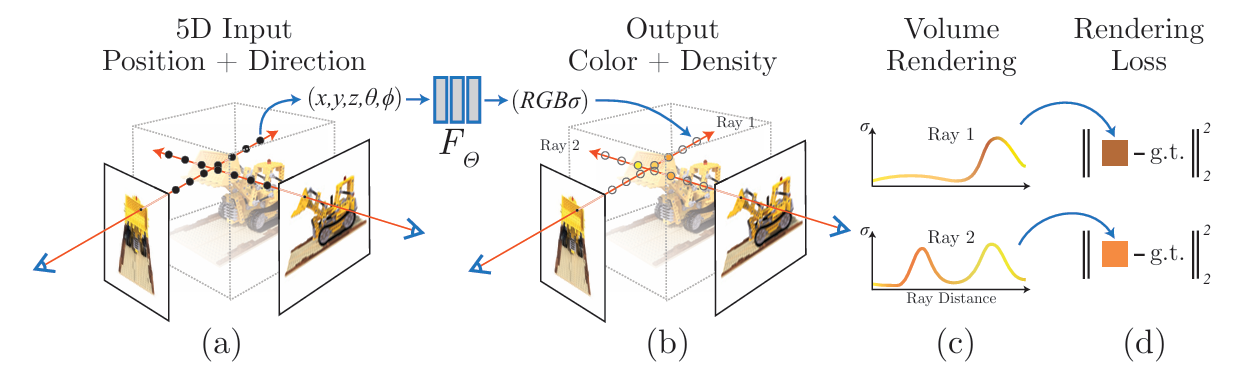

## Imports + Data


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import numpy as np
import torch.nn.functional as F
import os
from tqdm import tqdm
from ipywidgets import interactive, widgets

if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Encoding + Model

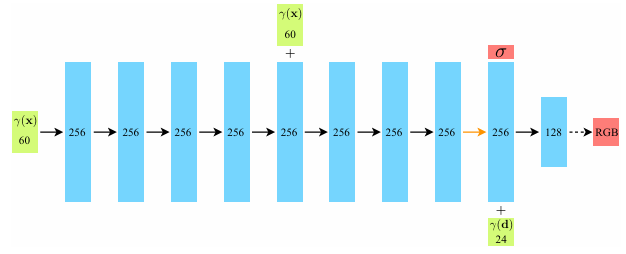

$$\gamma(p) = (\sin(2^0\pi p), \cos(2^0\pi p), \dots, \sin(2^{L-1}\pi p), \cos(2^{L-1}\pi p))$$

In [3]:
def encoding(x, L=10):
    rets = [x]
    for i in range(L):
        for fn in [torch.sin, torch.cos]:  # Use torch functions
            rets.append(fn(2. ** i * x))
    return torch.cat(rets, dim=-1)  # Concatenate along the last dimension

class NeRF(nn.Module):

  def __init__(self, pos_enc_dim = 63, view_enc_dim = 27, hidden = 256) -> None:
     super().__init__()

     self.linear1 = nn.Sequential(nn.Linear(pos_enc_dim,hidden),nn.ReLU())

     self.pre_skip_linear = nn.Sequential()
     for _ in range(4):
      self.pre_skip_linear.append(nn.Linear(hidden,hidden))
      self.pre_skip_linear.append(nn.ReLU())


     self.linear_skip = nn.Sequential(nn.Linear(hidden+pos_enc_dim,hidden),nn.ReLU())

     self.post_skip_linear = nn.Sequential()
     for _ in range(2):
      self.post_skip_linear.append(nn.Linear(hidden,hidden))
      self.post_skip_linear.append(nn.ReLU())

     self.density_layer = nn.Sequential(nn.Linear(hidden,1), nn.ReLU())

     self.linear2 = nn.Linear(hidden,hidden)

     self.color_linear1 = nn.Sequential(nn.Linear(hidden+view_enc_dim,hidden//2),nn.ReLU())
     self.color_linear2 = nn.Sequential(nn.Linear(hidden//2, 3),nn.Sigmoid())

     self.relu = nn.ReLU()
     self.sigmoid = nn.Sigmoid()


  def forward(self,input):

    # Extract pos and view dirs
    positions = input[..., :3]
    view_dirs = input[...,3:]

    # Encode
    pos_enc = encoding(positions,L=10)
    view_enc = encoding(view_dirs, L=4)

    x = self.linear1(pos_enc)
    x = self.pre_skip_linear(x)

    # Skip connection
    x = torch.cat([x, pos_enc], dim=-1)
    x = self.linear_skip(x)

    x = self.post_skip_linear(x)

    # Density prediction
    sigma = self.density_layer(x)

    x = self.linear2(x)

    # Incoroporate view encoding
    x = torch.cat([x, view_enc],dim=-1)
    x = self.color_linear1(x)

    # Color Prediction
    rgb = self.color_linear2(x)

    return torch.cat([sigma, rgb], dim=-1) 

## Get Ray + Render

In [4]:
def get_rays(H, W, focal, c2w):
  """
  Generate rays for a given camera configuration.

  Args:
    H: Image height.
    W: Image width.
    focal: Focal length.
    c2w: Camera-to-world transformation matrix (4x4).

  Returns:
    rays_o: Ray origins (H*W, 3).
    rays_d: Ray directions (H*W, 3).
  """
  device = c2w.device  # Get the device of c2w
  focal = torch.from_numpy(focal).to(device)
  # print(type(H), type(W), type(focal), type(c2w))

  i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32, device=device),
      torch.arange(H, dtype=torch.float32, device=device),
      indexing='xy'
  )
  dirs = torch.stack(
      [(i - W * .5) / focal, -(j - H * .5) / focal, -torch.ones_like(i, device = device)], -1
  )

  rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
  rays_d = rays_d.view(-1, 3)
  rays_o = c2w[:3, -1].expand(rays_d.shape)

  return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, device, rand=False, embed_fn=None, chunk=1024*4):
    def batchify(fn, chunk):
        return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Sampling
    z_vals = torch.linspace(near, far, steps=N_samples, device=device)

    if rand:
        z_vals += torch.rand(*z_vals.shape[:-1], N_samples, device=rays_o.device) * (far - near) / N_samples

    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Normalize view directions
    view_dirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    view_dirs = view_dirs[..., None, :].expand(pts.shape)

    input_pts = torch.cat((pts, view_dirs), dim=-1)
    raw = batchify(network_fn, chunk)(input_pts)

    # Apply activations here instead of in network
    sigma_a = raw[...,0]  # Shape: [batch, N_samples]
    rgb = raw[...,1:]    # Shape: [batch, N_samples, 3]

    # Improved volume rendering
    dists = z_vals[..., 1:] - z_vals[..., :-1]  # Shape: [batch, N_samples-1]
    dists = torch.cat([dists, torch.tensor([1e10], device=device)], -1)

    # No need to manually expand dists as broadcasting will handle it
    alpha = 1. - torch.exp(-sigma_a * dists)  # Shape: [batch, N_samples]
    alpha = alpha.unsqueeze(-1)  # Shape: [batch, N_samples, 1]

    # Computing transmittance
    ones_shape = (alpha.shape[0], 1, 1)
    T = torch.cumprod(
        torch.cat([
            torch.ones(ones_shape, device=device),
            1. - alpha + 1e-10
        ], dim=1),
        dim=1
    )[:, :-1]  # Shape: [batch, N_samples, 1]

    weights = alpha * T  # Shape: [batch, N_samples, 1]

    # Compute final colors and depths
    rgb_map = torch.sum(weights * rgb, dim=1)  # Sum along sample dimension
    depth_map = torch.sum(weights.squeeze(-1) * z_vals, dim=-1)  # Shape: [batch]
    acc_map = torch.sum(weights.squeeze(-1), dim=-1)  # Shape: [batch]

    return rgb_map, depth_map, acc_map

## Train Loop

In [5]:
def train(images,poses,H,W,focal,testpose,testimg,device):

    print(f"Using device: {device}")
    model = NeRF().to(device)

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    n_iter = 2000
    n_samples = 64
    i_plot = 50
    psnrs = []
    iternums = []
    t = time.time()

    # Convert data to tensors and move to device ONCE
    images_tensor = torch.from_numpy(images).float().to(device)
    poses_tensor = torch.from_numpy(poses).float().to(device)

    for i in range(n_iter):

        img_i = np.random.randint(images.shape[0])

        target = images_tensor[img_i]  # Use the corresponding image
        pose = poses_tensor[img_i]     # Use the corresponding pose

        rays_o, rays_d = get_rays(H, W, focal, pose)

        optimizer.zero_grad()

        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=n_samples, device=device, rand=True)

        rgb = rgb.reshape(H,W,3)

        loss = criterion(rgb, target)

        loss.backward()
        optimizer.step()

        if i % i_plot == 0:
            print(f'Iteration: {i}, Loss: {loss.item():.6f}, Time: {(time.time() - t) / i_plot:.2f} secs per iter')
            t = time.time()

            with torch.no_grad():
                rays_o, rays_d = get_rays(H, W, focal, testpose)
                rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6.,
                                           N_samples=n_samples, device=device)
                rgb = rgb.reshape(H, W, 3)
                loss = criterion(rgb, testimg)
                psnr = -10. * torch.log10(loss)

                psnrs.append(psnr.item())
                iternums.append(i)

                plt.figure(figsize=(10,4))
                plt.subplot(121)
                plt.imshow(rgb.cpu().detach())
                plt.title(f'Iteration: {i}')
                plt.subplot(122)
                plt.plot(iternums, psnrs)
                plt.title('PSNR')
                plt.show()

    return model

## Load Data

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


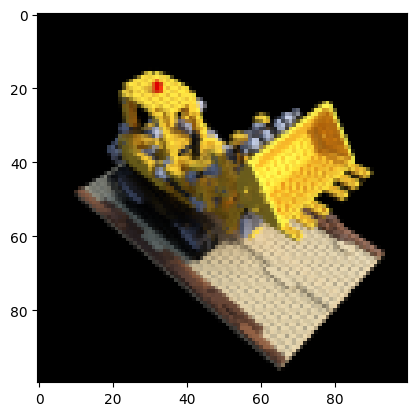

In [6]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)
device = "cuda" if torch.cuda.is_available() else "cpu"

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]
plt.imshow(testimg)
plt.show()
testimg =  torch.from_numpy(testimg).float().to("cuda")
testpose = torch.from_numpy(testpose).float().to("cuda")

## Train

Using device: cuda
Iteration: 0, Loss: 0.165847, Time: 0.01 secs per iter


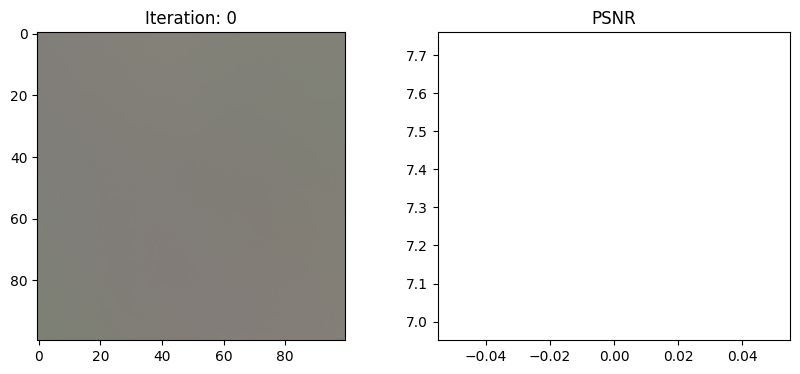

Iteration: 50, Loss: 0.038955, Time: 0.30 secs per iter


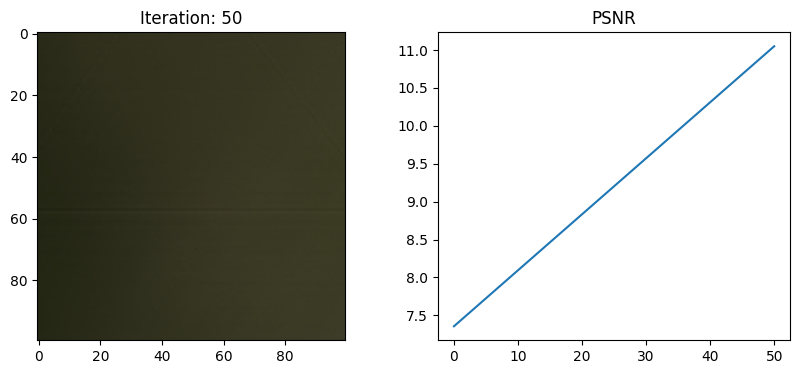

Iteration: 100, Loss: 0.051221, Time: 0.31 secs per iter


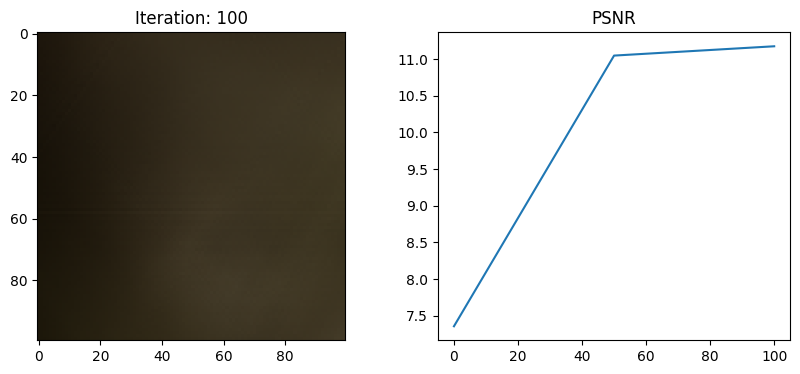

Iteration: 150, Loss: 0.026597, Time: 0.31 secs per iter


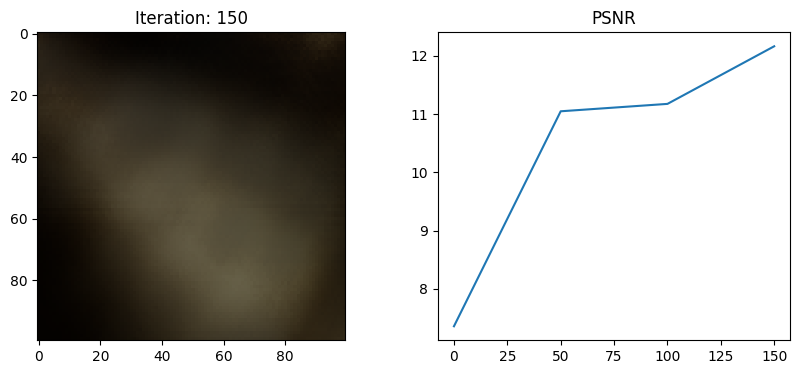

Iteration: 200, Loss: 0.018288, Time: 0.30 secs per iter


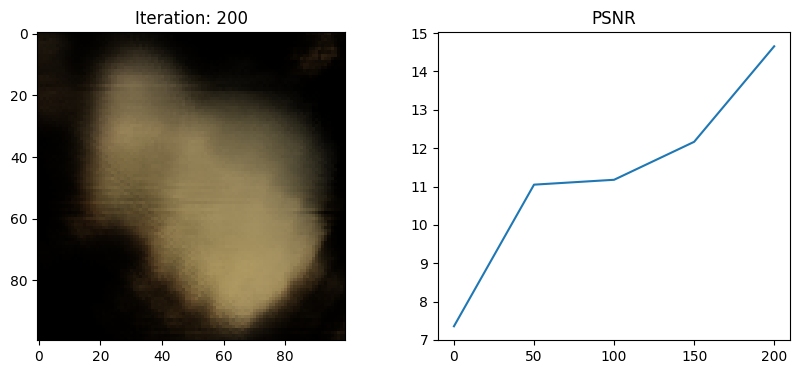

Iteration: 250, Loss: 0.010777, Time: 0.31 secs per iter


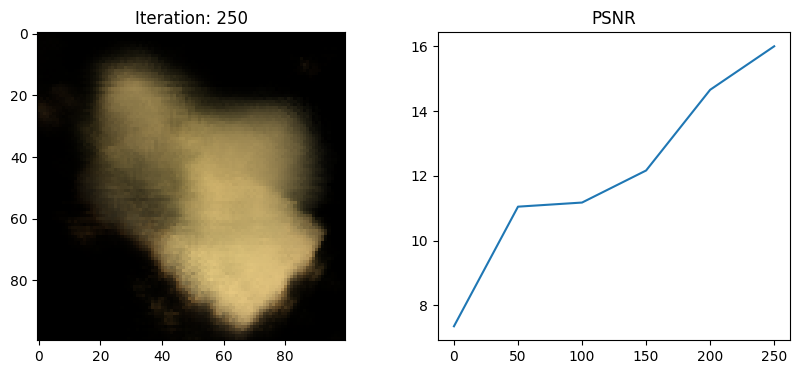

Iteration: 300, Loss: 0.022279, Time: 0.30 secs per iter


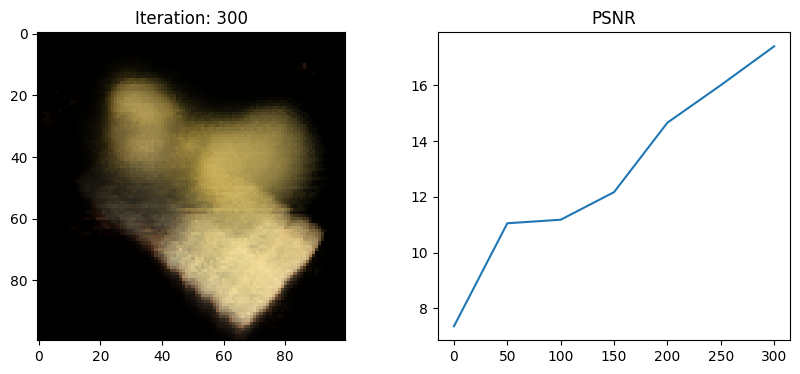

Iteration: 350, Loss: 0.015633, Time: 0.31 secs per iter


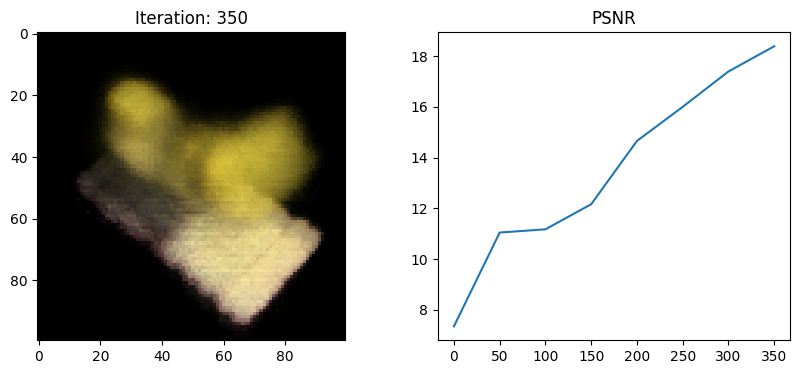

Iteration: 400, Loss: 0.014239, Time: 0.31 secs per iter


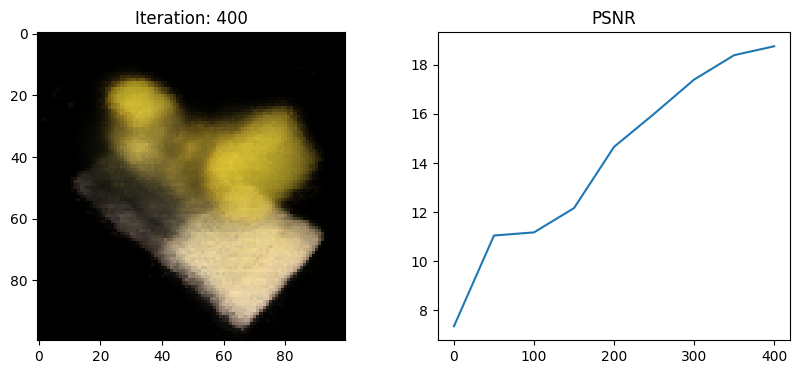

Iteration: 450, Loss: 0.013083, Time: 0.31 secs per iter


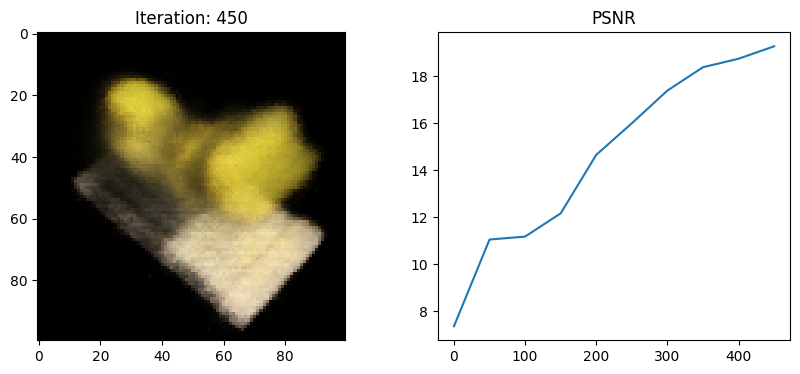

Iteration: 500, Loss: 0.009933, Time: 0.30 secs per iter


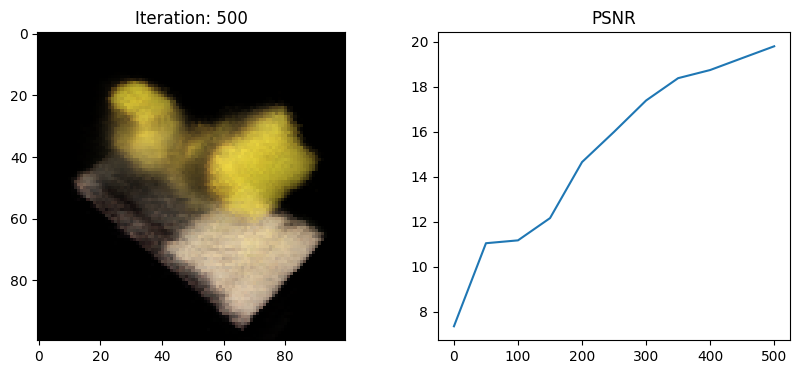

Iteration: 550, Loss: 0.010926, Time: 0.31 secs per iter


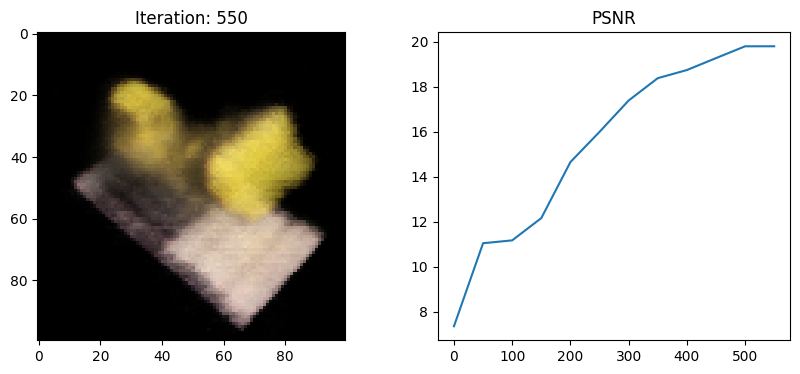

Iteration: 600, Loss: 0.006871, Time: 0.31 secs per iter


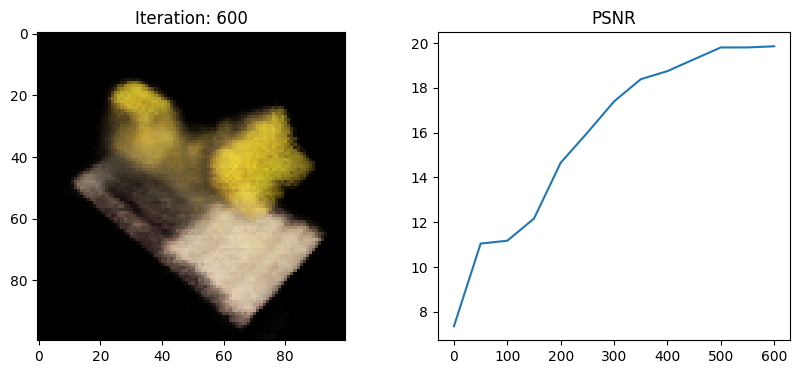

Iteration: 650, Loss: 0.009395, Time: 0.31 secs per iter


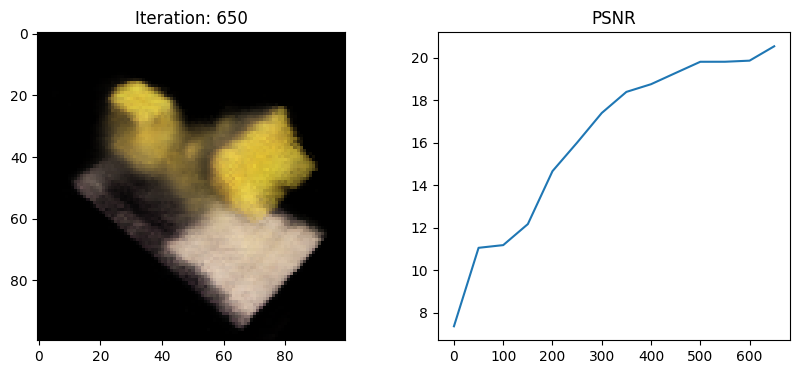

Iteration: 700, Loss: 0.006076, Time: 0.30 secs per iter


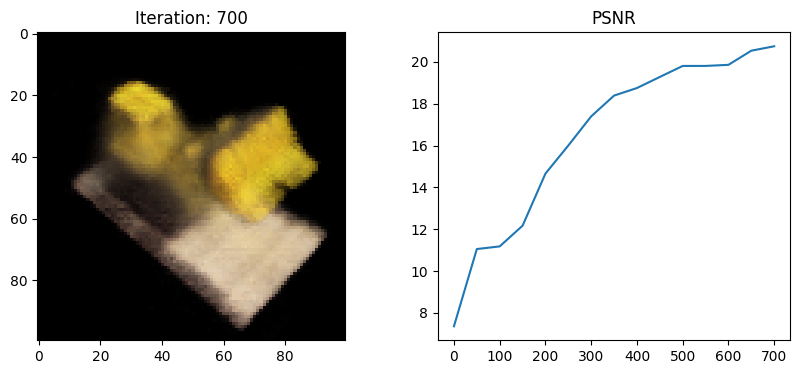

Iteration: 750, Loss: 0.008502, Time: 0.30 secs per iter


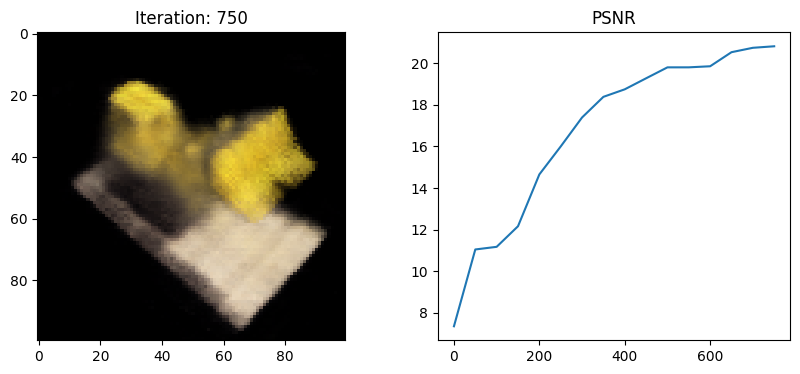

Iteration: 800, Loss: 0.008663, Time: 0.30 secs per iter


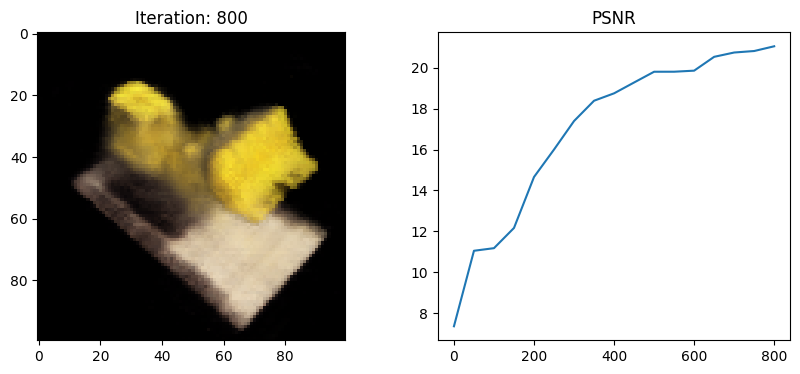

Iteration: 850, Loss: 0.005408, Time: 0.30 secs per iter


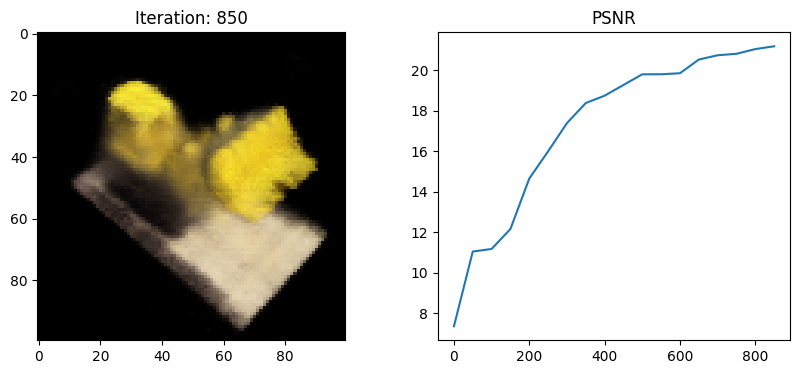

Iteration: 900, Loss: 0.008259, Time: 0.31 secs per iter


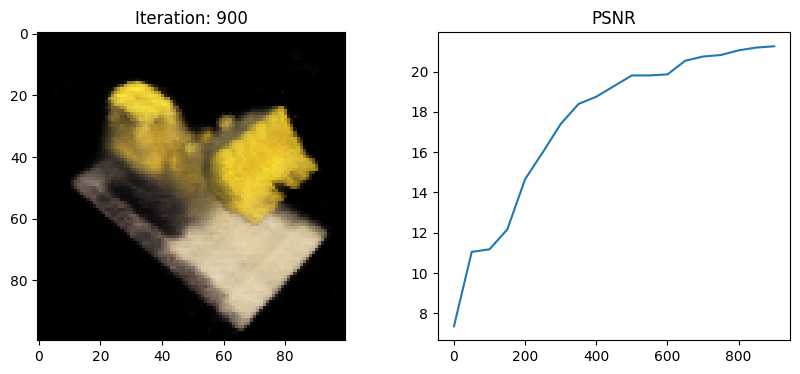

Iteration: 950, Loss: 0.008318, Time: 0.30 secs per iter


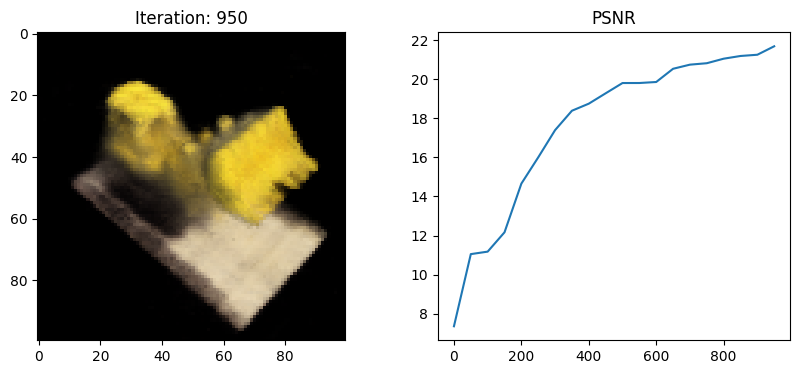

Iteration: 1000, Loss: 0.004318, Time: 0.30 secs per iter


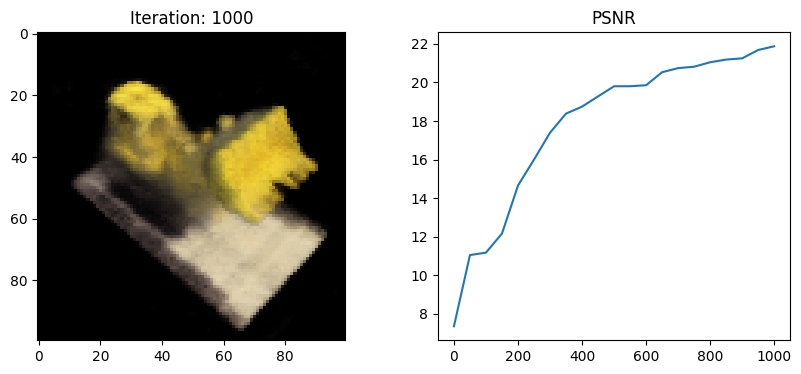

Iteration: 1050, Loss: 0.007921, Time: 0.30 secs per iter


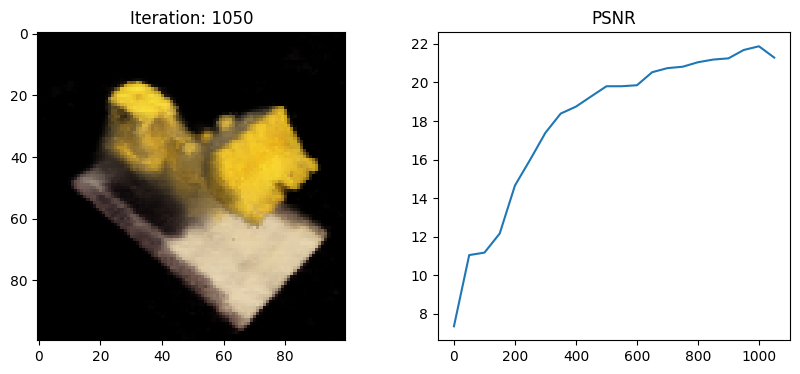

Iteration: 1100, Loss: 0.005039, Time: 0.30 secs per iter


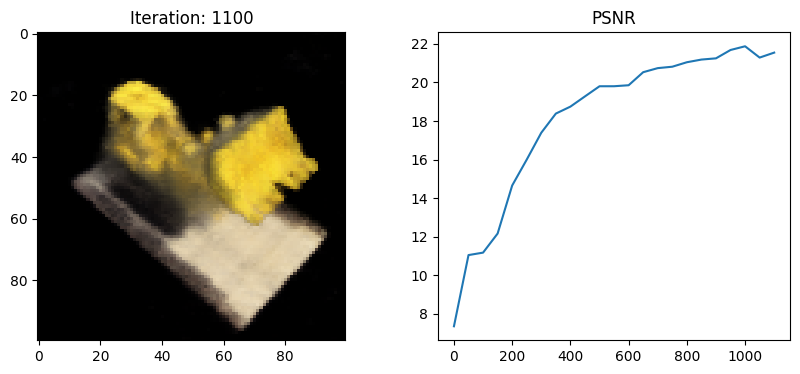

Iteration: 1150, Loss: 0.007081, Time: 0.30 secs per iter


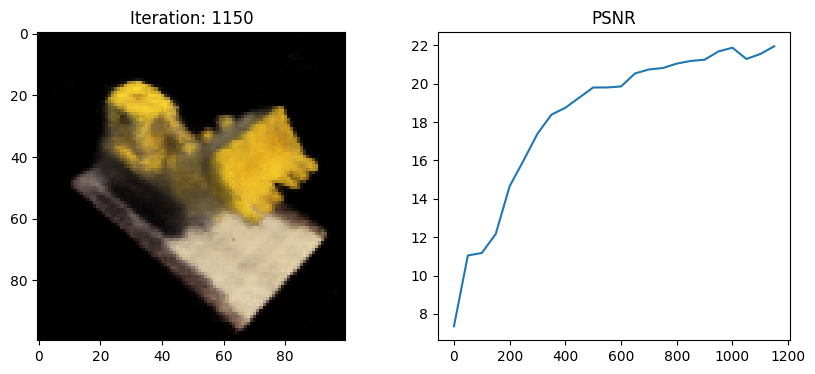

Iteration: 1200, Loss: 0.004002, Time: 0.30 secs per iter


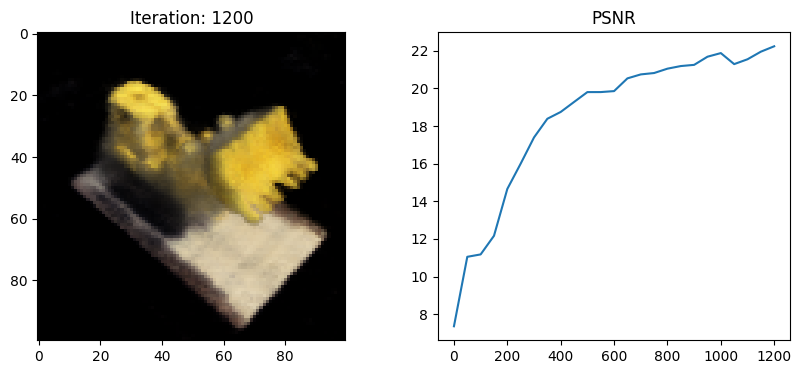

Iteration: 1250, Loss: 0.006729, Time: 0.31 secs per iter


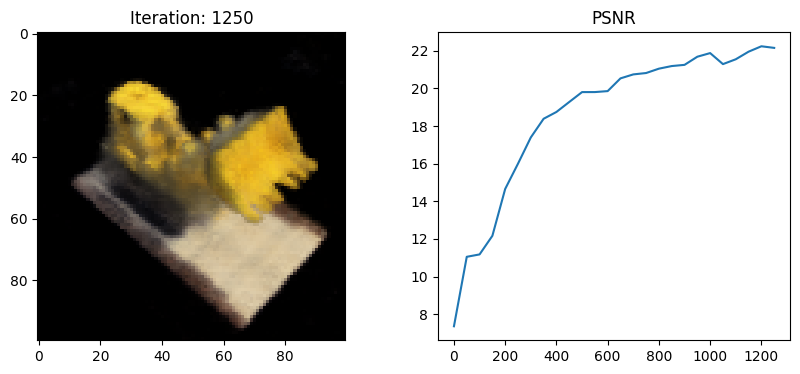

Iteration: 1300, Loss: 0.004636, Time: 0.30 secs per iter


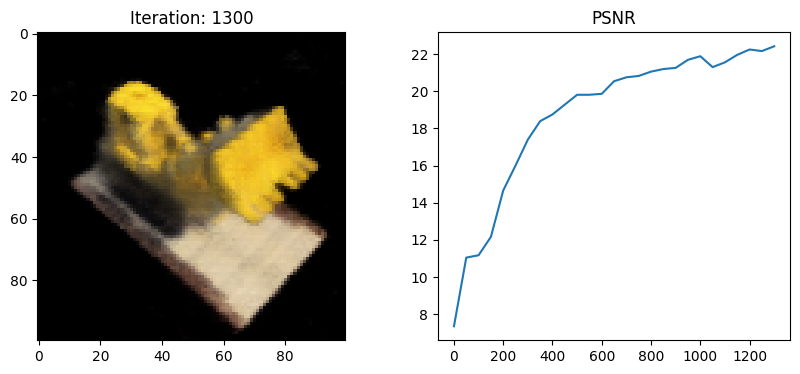

Iteration: 1350, Loss: 0.003582, Time: 0.31 secs per iter


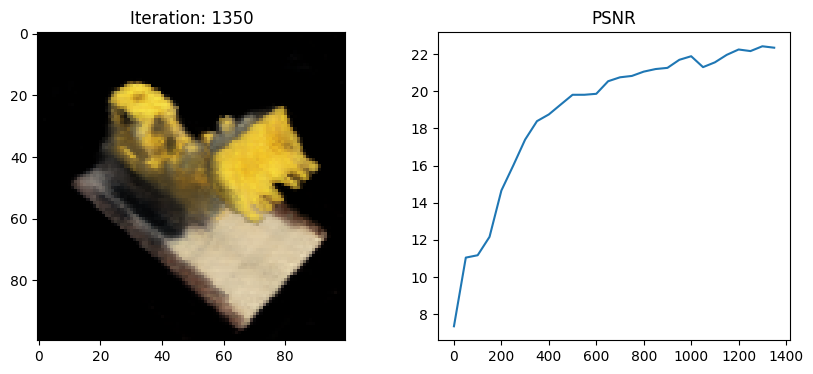

Iteration: 1400, Loss: 0.006065, Time: 0.31 secs per iter


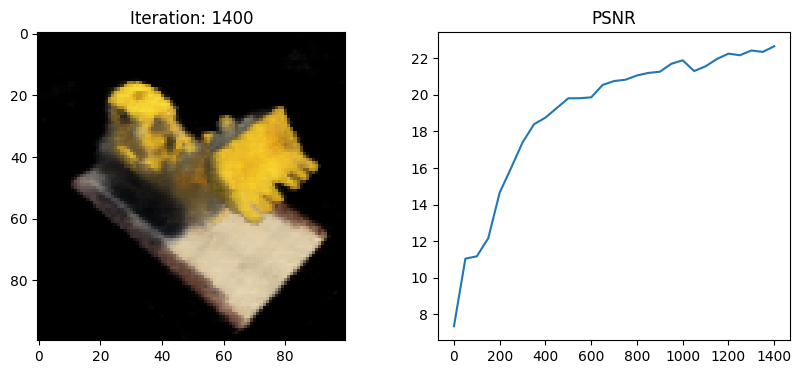

Iteration: 1450, Loss: 0.006200, Time: 0.31 secs per iter


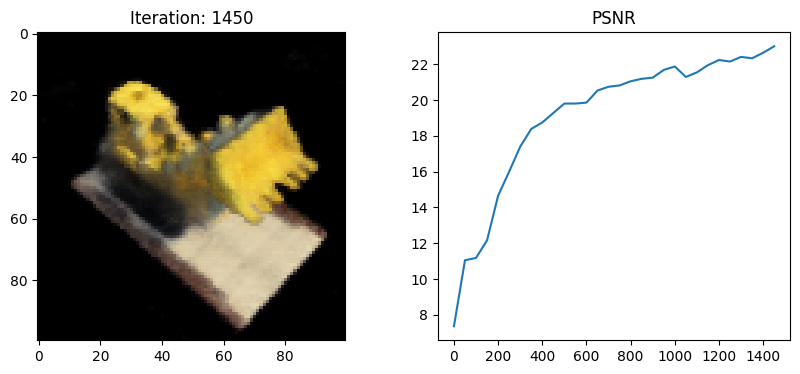

Iteration: 1500, Loss: 0.006984, Time: 0.31 secs per iter


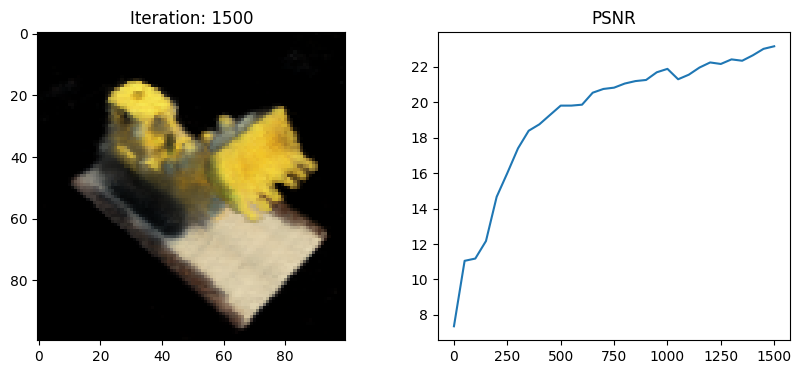

Iteration: 1550, Loss: 0.002644, Time: 0.31 secs per iter


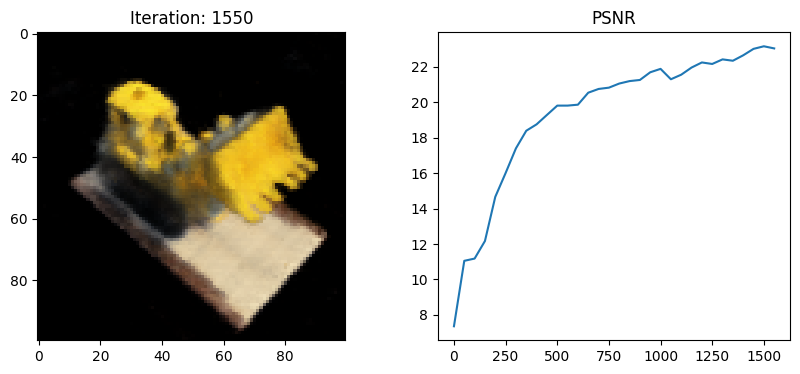

Iteration: 1600, Loss: 0.003954, Time: 0.31 secs per iter


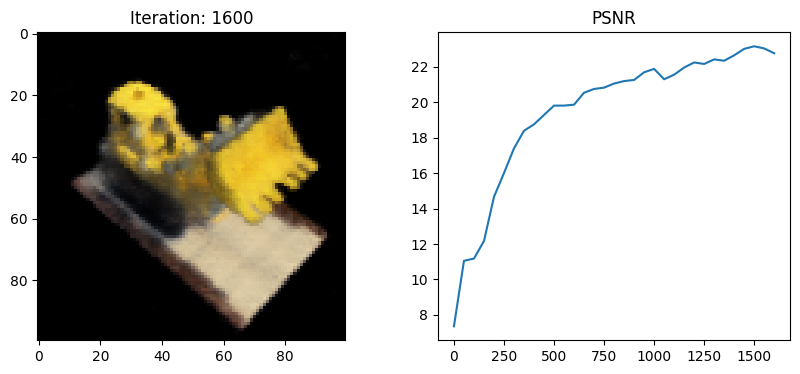

Iteration: 1650, Loss: 0.006341, Time: 0.31 secs per iter


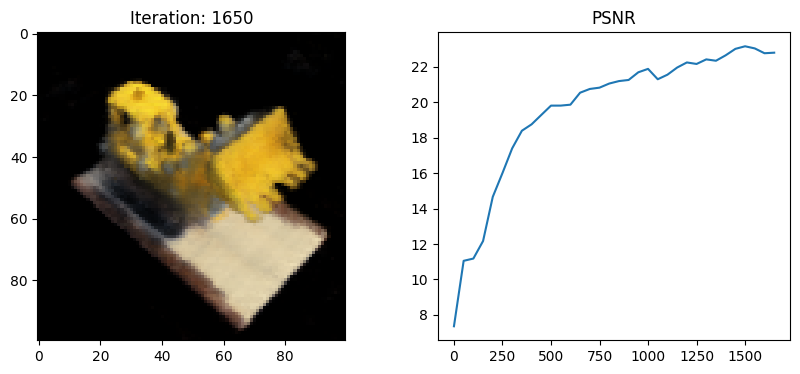

Iteration: 1700, Loss: 0.004006, Time: 0.31 secs per iter


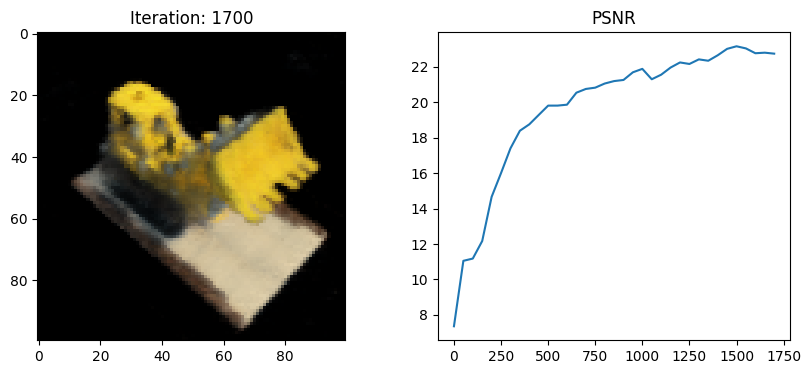

Iteration: 1750, Loss: 0.005270, Time: 0.31 secs per iter


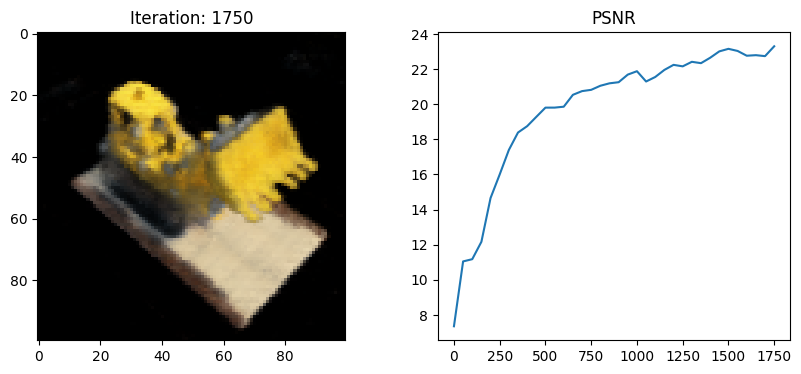

Iteration: 1800, Loss: 0.003421, Time: 0.31 secs per iter


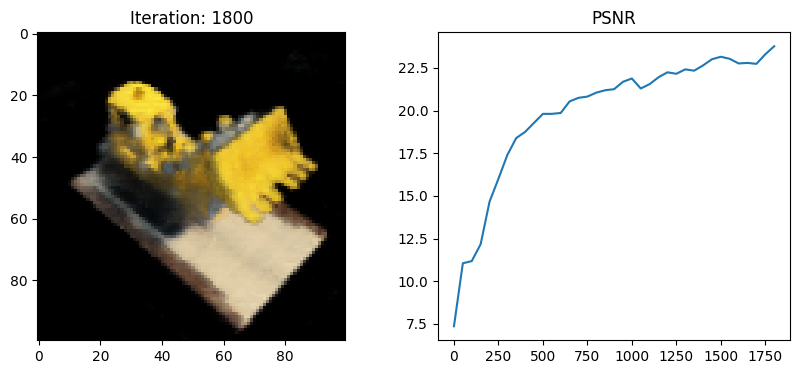

Iteration: 1850, Loss: 0.003005, Time: 0.31 secs per iter


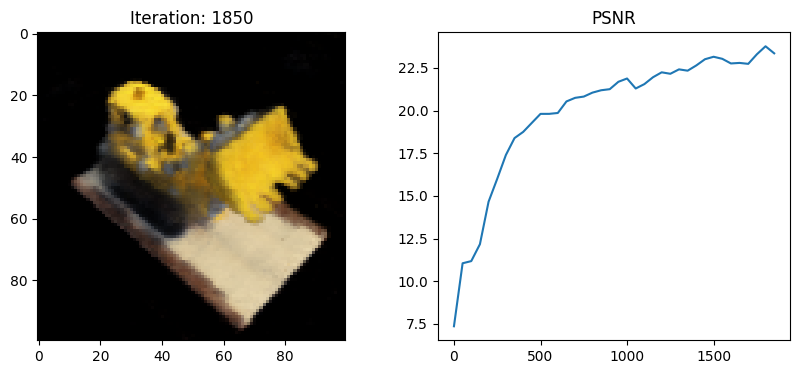

Iteration: 1900, Loss: 0.002853, Time: 0.31 secs per iter


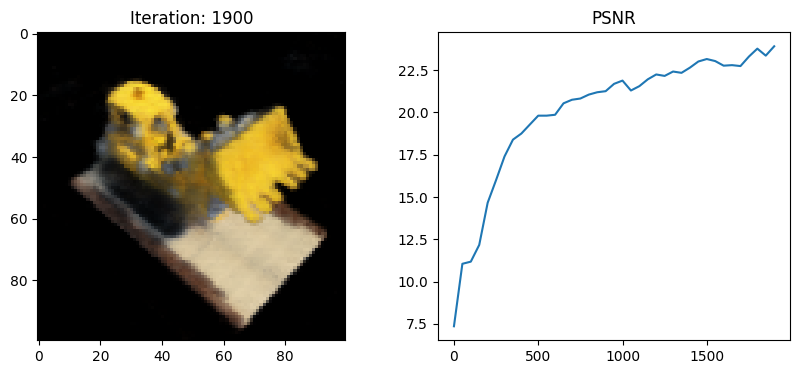

Iteration: 1950, Loss: 0.004220, Time: 0.30 secs per iter


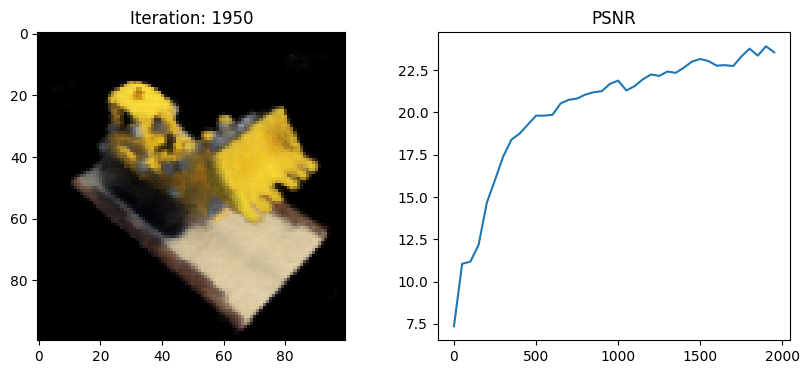

In [7]:
model = train(images,poses,H,W,focal,testpose,testimg,device)

## Render Video

In [ ]:
# Transformation matrices in PyTorch
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

# Pose function with spherical coordinates
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = torch.matmul(rot_phi(torch.Tensor([phi / 180. * np.pi])), c2w)
    c2w = torch.matmul(rot_theta(torch.Tensor([theta / 180. * np.pi])), c2w)
    c2w = torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32) @ c2w
    return c2w

# Function for rendering based on user input
def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])  # Get rays (this is a placeholder)
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device=device)  # Render rays
    rgb = rgb.reshape(H, W, 3).cpu().detach()
    img = torch.clamp(rgb, 0, 1).numpy()  # Clamp RGB values between 0 and 1 and convert to numpy

    plt.figure(2, figsize=(20, 6))
    plt.imshow(img)
    plt.show()

# Interactive slider setup for theta, phi, and radius
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [9]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device = device)
    rgb = rgb.reshape(H, W, 3)
    frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:15<00:00,  7.65it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [10]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)